# Ego Goal Step

goal step is completely downloaded with both dataset and annotation
"ego4d -o <out-dir> --dataset annotations full_scale --benchmarks goalstep"

- github link
https://github.com/facebookresearch/ego4d-goalstep


- visualizing on browser
https://visualize.ego4d-data.org/?q=%22benchmarks+include+goalstep%22

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
ego4d_json = json.load(open("../data/egogoal/ego4d.json"))
egogoal_nonann_data = json.load(open("../data/egogoal/v2/annotations/goalstep_test_unannotated.json"))
egogoal_ann_train_data = json.load(open("../data/egogoal/v2/annotations/goalstep_train.json"))
egogoal_nonann_trainval_data = json.load(open("../data/egogoal/v2/annotations/goalstep_trainval.json"))
egogoal_nonann_val_data = json.load(open("../data/egogoal/v2/annotations/goalstep_val.json"))


### Parsing the json

highest levels Index(['version', 'date', 'descriptin', 'split', 'videos'])
- version: data version
- date
- description: "Ego4D Goal-Step
- split : train, test, val or trainval
- videos : holds the nested annotation format decribed in lower cell

In [3]:
import pandas as pd
test_df = df = pd.json_normalize(egogoal_nonann_data)
train_df = df = pd.json_normalize(egogoal_ann_train_data)
val_df = df = pd.json_normalize(egogoal_nonann_val_data)
trainval_df = df = pd.json_normalize(egogoal_nonann_trainval_data)

print("test: ", test_df.columns)
print("train: ", train_df.columns)
print("val: ", val_df.columns)
print("trainval: ", trainval_df.columns)


test:  Index(['version', 'date', 'description', 'split', 'videos'], dtype='object')
train:  Index(['version', 'date', 'description', 'split', 'videos'], dtype='object')
val:  Index(['version', 'date', 'description', 'split', 'videos'], dtype='object')
trainval:  Index(['version', 'date', 'description', 'videos'], dtype='object')


### Annotation format of Index['videos']

hierarchy of 1st(goal_XXX) -> 2nd(segments:step_category) -> 3rd(segments:step_category)

- video_uid: unique video ID
- start_time: A timestamp where a goal segment starts (in seconds)
- end_time: A timestamp where a goal segment ends (in seconds)
- goal_category: Goal category name
- goal_description: Natural language description of the goal
- goal_wikihow_url: A wikiHow URL that best captures the steps captured in the video
- summary: A list of natural language descriptions summarizing steps captured in the video
- is_procedural: Binary flag indicating whether the current segment contains procedural steps
- segments: A list of step segments
  - start_time: A timestamp where a step segment starts (in seconds)
  - end_time: A timestamp where a step segment ends (in seconds)
  - step_category: Step category name (shares the same taxonomy with substep categegories)
  - step_description: Natural language description of the step
  - is_continued: Binary flag indicating whether the current segment contains a step that is continued from an earlier segment
  - is_procedural: Binary flag indicating whether the current segment contains procedural steps
  - is_relevant: A flag indicating whether the current segment is essential, optional, or irrelevant to the (parent) goal segment
  - summary: A list of natural language descriptions summarizing substeps captured in the video
    - segments: A list of substep segments
...

39d087b0-afc2-47d8-ba91-b70dd8fab90e


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (3).

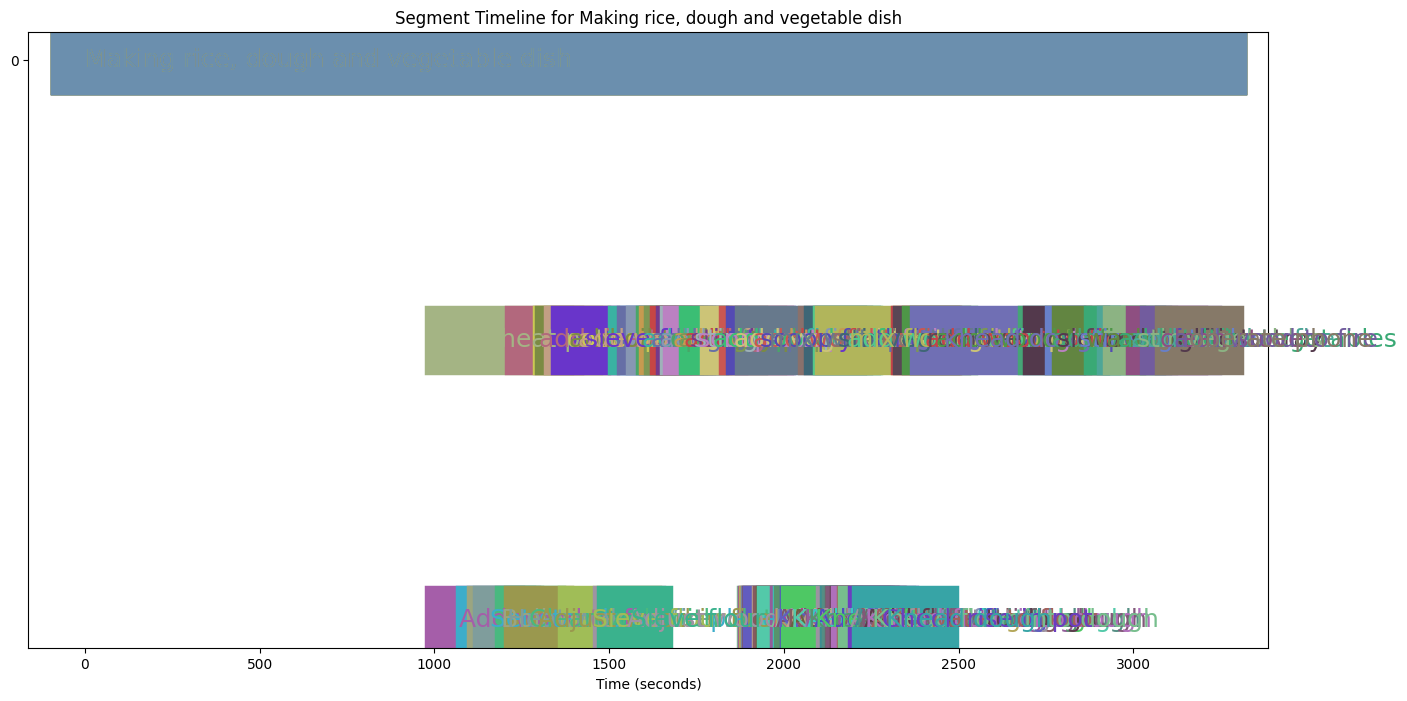

In [19]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# JSON files
# egogoal_nonann_data
# egogoal_ann_train_data
# egogoal_nonann_trainval_data
# egogoal_nonann_val_data


# Function to assign a random color to each segment
def get_random_color():
    return [random.uniform(0.2, 0.8) for _ in range(3)]

# Function to create timeline visualization
def plot_segments(video_data):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot the first-level segments (summary)
    y_level = 0  # y-position for the first level
    for i, summary in enumerate(video_data['summary']):
        color = get_random_color()
        ax.plot(
            [video_data['start_time'], video_data['end_time']],
            [y_level, y_level],
            color=color,
            linewidth=50,
            label=f"Level 1: {video_data['goal_description']}" if i == 0 else None
        )
        ax.text(video_data['start_time'], y_level, video_data['goal_description'], verticalalignment='center', fontsize=18, color=color)
    
    # Plot second-level segments (nested in segments)
    y_level -= 1  # y-position for the second level
    for i, segment in enumerate(video_data['segments']):
        color = get_random_color()
        ax.plot(
            [segment['start_time'], segment['end_time']],
            [y_level, y_level],
            color=color,
            linewidth=50,
            label=f"Level 2: {segment['step_description']}" if i == 0 else None
        )
        ax.text(segment['start_time'], y_level, segment['step_description'], verticalalignment='center', fontsize=18, color=color)
        
        # Plot third-level segments (nested within second-level segments)
         # y-position for third level
        for j, sub_segment in enumerate(segment['segments']):
            y_level = -2 
            sub_color = get_random_color()
            ax.plot(
                [sub_segment['start_time'], sub_segment['end_time']],
                [y_level, y_level],
                color=sub_color,
                linewidth=50,
                label=f"Level 3: {sub_segment['step_description']}" if i == 0 and j == 0 else None
            )
            ax.text(sub_segment['start_time'], y_level, sub_segment['step_description'], verticalalignment='center', fontsize=18, color=sub_color)
        
        y_level = -1  # space between segment levels
    
    # Add labels and legend
    ax.set_title(f"Segment Timeline for {video_data['goal_description']}")
    ax.set_xlabel("Time (seconds)")
    ax.set_yticks(range(0, y_level, -1))
    ax.set_yticklabels(["Level 1", "Level 2", "Level 3"])
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    
    # Create a legend with custom labels for each level
    level1_patch = mpatches.Patch(color='blue', label='Level 1: Main Summary')
    level2_patch = mpatches.Patch(color='orange', label='Level 2: Cooking Steps')
    level3_patch = mpatches.Patch(color='green', label='Level 3: Sub-Steps')
    plt.legend(handles=[level1_patch, level2_patch, level3_patch], loc='upper right')
    
    # Display plot
    plt.tight_layout()
    plt.show()


# Call the function to plot segments

video = egogoal_ann_train_data['videos'][0]
print(egogoal_ann_train_data['videos'][0]['video_uid'])
plot_segments(video)



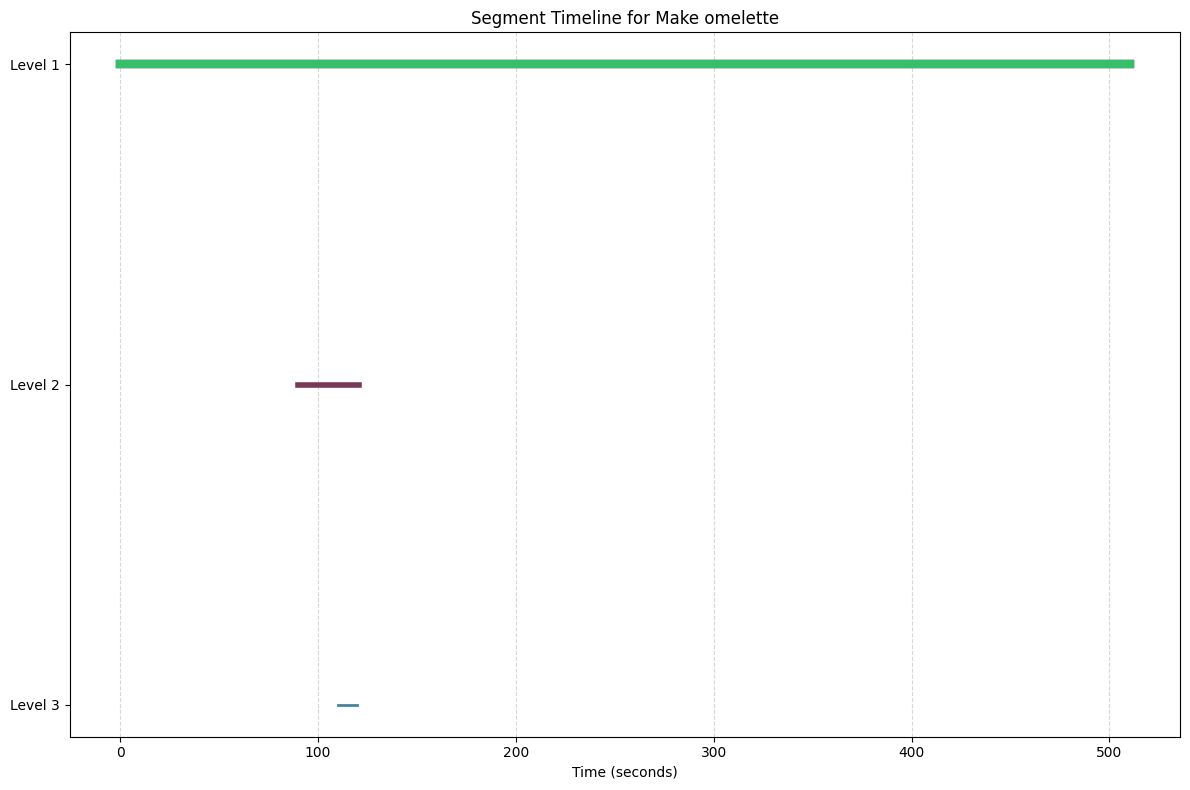

In [28]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# Sample data structure to mimic JSON format
data = {
    "videos": [
        {
            "video_uid": "9b58e3ab-7b6d-4e79-9eea-c21420b0eedc",
            "start_time": 0.021,
            "end_time": 510.187,
            "goal_description": "Make omelette",
            "summary": [
                "Toasting bread on a pan",
                "Making omelet",
                "Serving omelet with ketchup"
            ],
            "segments": [
                {
                    "start_time": 0,
                    "end_time": 56.99,
                    "step_description": "Toast bread",
                    "summary": ["heat skillet", "toast bread", "trash kitchen waste"],
                    "segments": [
                        {
                            "start_time": 0,
                            "end_time": 13.13,
                            "step_description": "preheat the stove-top",
                            "summary": ["turn on stove", "preheat the stove-top"]
                        }
                    ]
                }
            ],
            "segments": [
                {
                    "start_time": 90,
                    "end_time": 120.99,
                    "step_description": "Toast bread",
                    "summary": ["heat skillet", "toast bread", "trash kitchen waste"],
                    "segments": [
                        {
                            "start_time": 110,
                            "end_time": 120,
                            "step_description": "preheat the stove-top",
                            "summary": ["turn on stove", "preheat the stove-top"]
                        }
                    ]
                }
            ]            
        }
    ]
}

# Extract video data
video = data['videos'][0]

# Function to assign a random color
def get_random_color():
    return [random.uniform(0.2, 0.8) for _ in range(3)]

# Plotting function with hover functionality
def plot_segments_with_hover(video_data):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Initialize an annotation box that will appear on hover
    hover_annotation = ax.annotate(
        "", xy=(0, 0), xytext=(10, 10), textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),
        arrowprops=dict(arrowstyle="->")
    )
    hover_annotation.set_visible(False)

    # Plot first-level segments (summary)
    y_level = 0  # y-position for the first level
    for i, summary in enumerate(video_data['summary']):
        color = get_random_color()
        segment_line = ax.plot(
            [video_data['start_time'], video_data['end_time']],
            [y_level, y_level],
            color=color, linewidth=6, label=summary
        )[0]
        
        # Event handling function for hover
        def on_hover(event, line=segment_line, label=summary):
            if line.contains(event)[0]:
                hover_annotation.set_text(label)
                hover_annotation.xy = (event.xdata, event.ydata)
                hover_annotation.set_visible(True)
                fig.canvas.draw_idle()
            else:
                hover_annotation.set_visible(False)
        
        fig.canvas.mpl_connect("motion_notify_event", on_hover)
    
    # Second-level segments
    y_level -= 1
    for i, segment in enumerate(video_data['segments']):
        color = get_random_color()
        segment_line = ax.plot(
            [segment['start_time'], segment['end_time']],
            [y_level, y_level],
            color=color, linewidth=4, label=segment['step_description']
        )[0]
        
        def on_hover(event, line=segment_line, label=segment['step_description']):
            if line.contains(event)[0]:
                hover_annotation.set_text(label)
                hover_annotation.xy = (event.xdata, event.ydata)
                hover_annotation.set_visible(True)
                fig.canvas.draw_idle()
            else:
                hover_annotation.set_visible(False)
        
        fig.canvas.mpl_connect("motion_notify_event", on_hover)
        
        # Third-level segments
        y_level -= 1
        for j, sub_segment in enumerate(segment['segments']):
            sub_color = get_random_color()
            segment_line = ax.plot(
                [sub_segment['start_time'], sub_segment['end_time']],
                [y_level, y_level],
                color=sub_color, linewidth=2, label=sub_segment['step_description']
            )[0]
            
            def on_hover(event, line=segment_line, label=sub_segment['step_description']):
                if line.contains(event)[0]:
                    hover_annotation.set_text(label)
                    hover_annotation.xy = (event.xdata, event.ydata)
                    hover_annotation.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    hover_annotation.set_visible(False)
            
            fig.canvas.mpl_connect("motion_notify_event", on_hover)
        
        y_level -= 1  # space between levels
    
    # Set plot details
    ax.set_title(f"Segment Timeline for {video_data['goal_description']}")
    ax.set_xlabel("Time (seconds)")
    ax.set_yticks(range(0, y_level, -1))
    ax.set_yticklabels(["Level 1", "Level 2", "Level 3"])
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Run the function
plot_segments_with_hover(video)


ValueError: The number of FixedLocator locations (79), usually from a call to set_ticks, does not match the number of labels (3).

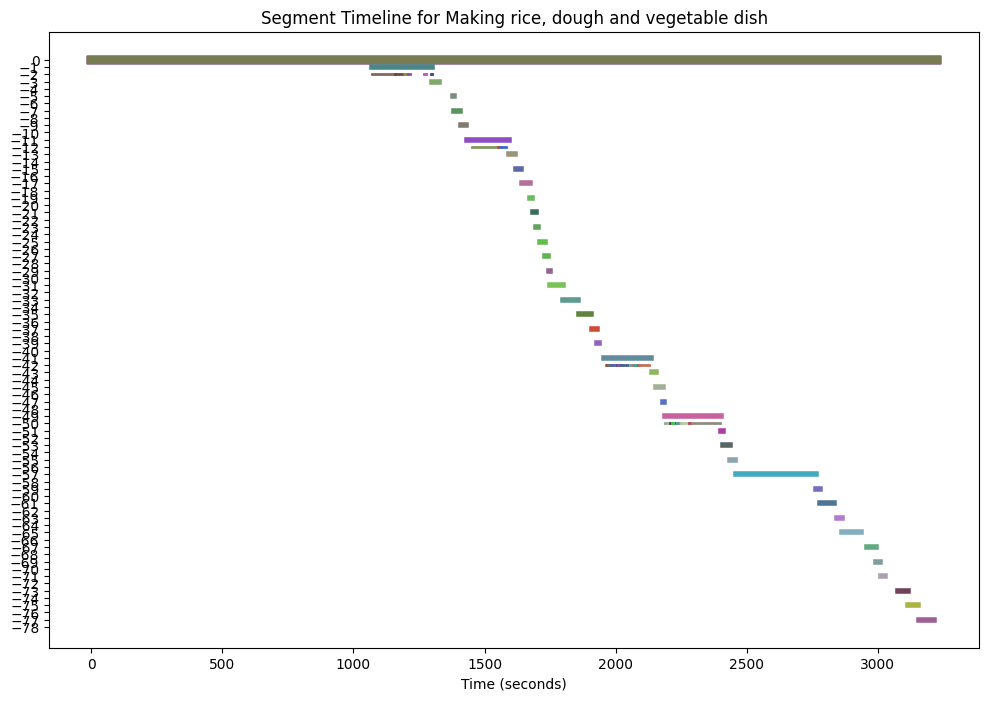

In [22]:
import json
import matplotlib.pyplot as plt
import random

# Load JSON file
# with open('your_json_file.json', 'r') as file:
#     data = json.load(file)

data = egogoal_ann_train_data

# Extract video data (assuming only one video in this case)
video = data['videos'][0]

# Function to assign a random color to each segment
def get_random_color():
    return [random.uniform(0.2, 0.8) for _ in range(3)]

# Function to create timeline visualization with hover text
def plot_segments(video_data):
    fig, ax = plt.subplots(figsize=(12, 8))
    segments = []  # Store segments to enable hover detection

    # Tooltip text
    tooltip = ax.text(0, 0, "", fontsize=9, color='black', bbox=dict(facecolor='yellow', alpha=0.7))
    tooltip.set_visible(False)

    # Function to check if cursor is over a line segment
    def on_hover(event):
        visible = False
        for segment in segments:
            line, label = segment
            cont, _ = line.contains(event)
            if cont:
                tooltip.set_text(label)
                tooltip.set_position((event.xdata, event.ydata))
                tooltip.set_visible(True)
                visible = True
                break
        if not visible:
            tooltip.set_visible(False)
        fig.canvas.draw_idle()

    # Plot the first-level segments (summary)
    y_level = 0  # y-position for the first level
    for i, summary in enumerate(video_data['summary']):
        color = get_random_color()
        line = ax.plot(
            [video_data['start_time'], video_data['end_time']],
            [y_level, y_level],
            color=color,
            linewidth=6
        )[0]  # Capture the line object
        segments.append((line, f"Level 1: {summary}"))
    
    # Plot second-level segments (nested in segments)
    y_level -= 1  # y-position for the second level
    for segment in video_data['segments']:
        color = get_random_color()
        line = ax.plot(
            [segment['start_time'], segment['end_time']],
            [y_level, y_level],
            color=color,
            linewidth=4
        )[0]  # Capture the line object
        segments.append((line, f"Level 2: {segment['step_description']}"))
        
        # Plot third-level segments (nested within second-level segments)
        y_level -= 1  # y-position for third level
        for sub_segment in segment['segments']:
            sub_color = get_random_color()
            line = ax.plot(
                [sub_segment['start_time'], sub_segment['end_time']],
                [y_level, y_level],
                color=sub_color,
                linewidth=2
            )[0]  # Capture the line object
            segments.append((line, f"Level 3: {sub_segment['step_description']}"))
        
        y_level -= 1  # space between segment levels

    # Set plot labels and formatting
    ax.set_title(f"Segment Timeline for {video_data['goal_description']}")
    ax.set_xlabel("Time (seconds)")
    ax.set_yticks(range(0, y_level, -1))
    ax.set_yticklabels(["Level 1", "Level 2", "Level 3"])
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Connect hover event to figure
    fig.canvas.mpl_connect("motion_notify_event", on_hover)

    # Display plot
    plt.tight_layout()
    plt.show()

# Call the function to plot segments
plot_segments(video)


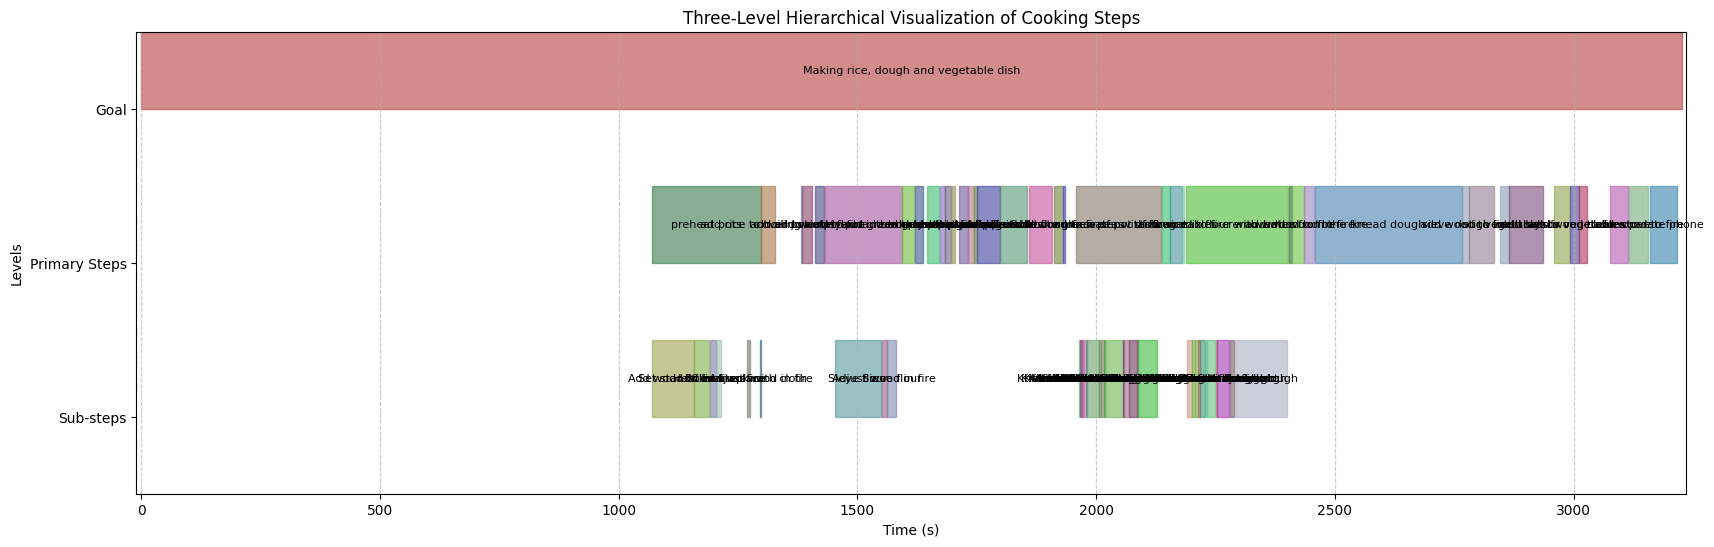

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Your JSON data parsed into a Python dictionary
video_data = {
    "start_time": 0.01,
    "end_time": 2000,
    "goal_description": "Making rice, dough and vegetable dish",
    
    "segments": [
        
        {
            "start_time": 0.348,
            "end_time": 1298.594,
            "step_description": "Preheat pots",
            "segments": [
                {
                    "start_time": 270.09237,
                    "end_time": 758.54893,
                    "step_description": "Add wood to fire"
                },
                {
                    "start_time": 1158.78141,
                    "end_time": 1189.912,
                    "step_description": "Set stands on fireplace"
                },
                # Add more sub-segments as needed
            ]
        },

        {
            "start_time": 1298.66082,
            "end_time": 1327.0985,
            "step_description": "Add rice to boiling water",
            "segments": []
        },
        # Add more segments as needed
    ]
}


# Function to assign a random color to each segment
def get_random_color():
    return [random.uniform(0.2, 0.8) for _ in range(3)]

# Helper function to add a rectangle for each segment
def add_segment(ax, start, end, level, description, color):
    # give random color
    color = get_random_color()
    rect = patches.Rectangle((start, level), end - start, 0.5, color=color, alpha=0.6)
    ax.add_patch(rect)
    ax.text(
        (start + end) / 2, level + 0.25, description, ha="center", va="center", fontsize=8
    )

def draw_segments(video_data):
    # Set up plot
    fig, ax = plt.subplots(figsize=(20, 6))
    y_levels = [3, 2, 1]  # Y-axis levels for 3 levels

    # Define color map for levels
    level_colors = {
        1: "lightcoral",
        2: "skyblue",
        3: "lightgreen",
    }



    # Plot level 1 (Main goal)
    main_goal_start = video_data["start_time"]
    main_goal_end = video_data["end_time"]
    add_segment(
        ax, main_goal_start, main_goal_end, y_levels[0],
        video_data["goal_description"], level_colors[1]
    )

    # Plot level 2 (Primary steps)
    for primary_step in video_data["segments"]:
        add_segment(
            ax, primary_step["start_time"], primary_step["end_time"], y_levels[1],
            primary_step["step_description"], level_colors[2]
        )
        
        # Plot level 3 (Sub-steps)
        for sub_step in primary_step.get("segments", []):
            add_segment(
                ax, sub_step["start_time"], sub_step["end_time"], y_levels[2],
                sub_step["step_description"], level_colors[3]
            )

    # Customize plot
    ax.set_ylim(0.5, 3.5)
    ax.set_xlim(main_goal_start - 10, main_goal_end + 10)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Levels")
    ax.set_yticks(y_levels)
    ax.set_yticklabels(["Goal", "Primary Steps", "Sub-steps"])
    ax.set_title("Three-Level Hierarchical Visualization of Cooking Steps")
    ax.grid(True, axis="x", linestyle="--", alpha=0.7)

    plt.show()

# draw_segments(video_data)

data = egogoal_ann_train_data

# Extract video data (assuming only one video in this case)
video = data['videos'][0]

draw_segments(video)

<!-- ann_data = json.load(open("../data/ego4d/v2/annotations/nlq_train.json"))
fho_sta_data = json.load(open("../data/ego4d/v2/annotations/fho_sta_train.json")) -->